# 3D Boxes (APC renderer)

Render APC-style 3D cubes using the built-in `RenderModule`.
Provide your `abstract_scene_dict` and get a rendered PIL image.


In [151]:
import os

In [152]:
# Force reload the renderer module to ensure we get our changes
import importlib
import apc.renderer
importlib.reload(apc.renderer)
print("Reloaded renderer module")

Reloaded renderer module


In [153]:
import os
# Configure headless rendering environment
os.environ['PYGLET_HEADLESS'] = '1'
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'  # Use OSMesa for software rendering
os.environ['DISPLAY'] = ':0'  # Fallback display

# Try importing key components to diagnose what's available
try:
    import OpenGL
    print("OpenGL version:", OpenGL.__version__)
    from OpenGL import GL
    print("GL import ok")
    import pyglet
    print("pyglet version info:", pyglet.version)  # Use pyglet.version instead of __version__
    # Force software rendering
    pyglet.options['shadow_window'] = False
    pyglet.options['debug_gl'] = False
except ImportError as e:
    print("Import failed:", str(e))
    print("Try: pip install 'pyglet==1.5.27' PyOpenGL PyOpenGL-accelerate")

OpenGL version: 3.1.10
GL import ok
pyglet version info: 1.5.27


In [154]:
import numpy as np
from IPython.display import display
# RenderModule (local renderer)
from apc.renderer import RenderModule

## Define your abstract scene
Positions are in 3D (x, y, z), orientation is a 3D direction vector.
The 'camera' entry is preserved but not drawn.


In [155]:
abstract_scene_dict = {
    'camera': {
        'position': np.array([0, 0, 0]),
        'orientation': np.array([0, 0, 1]),
    },
    'obj_a': {
        'position': np.array([1.0, 2.0, -4.0]),  # Moved closer to camera
        'orientation': np.array([1.0, 0.5, 0.0]),  # Point more along X axis with some Y tilt
    },
    'obj_b': {
        'position': np.array([1.5, -2.0, -5.0]),  # Moved closer to camera
        'orientation': np.array([1.0, 1, 0.0]),  # Point straight up along Y axis
    },
}


## Convert to renderer format + draw
APC renderer expects TriMesh convention and a color per object.


In [156]:
# Colors: name + RGB in 0..1
color_dict = [
    ['blue',   [0, 0, 1]],
    # ['red',    [1, 0, 0]],
    ['green',  [0, 1, 0]],
    ['yellow', [1, 1, 0]],
    ['purple', [1, 0, 1]],
    ['orange', [1, 0.5, 0]],
    ['brown',  [0.5, 0.25, 0]],
    ['gray',   [0.5, 0.5, 0.5]],
]

def to_trimesh_scene(scene: dict, ref_viewer: str = 'camera') -> dict:
    out = {}
    color_idx = 0  # Separate counter for non-camera objects
    
    for name, entry in scene.items():
        if name == ref_viewer:
            continue  # Skip camera object

        pos = np.array(entry['position']).copy()
        ori = np.array(entry['orientation']).copy()
        
        # Normalize orientation before conversion
        # ori = ori / np.linalg.norm(ori)
        
        # Copy colors with proper indexing
        color = color_dict[color_idx % len(color_dict)]
        color_idx += 1
        
        out[name] = {
            'position': pos,
            'orientation': ori,
            'color': color,
            'original_pos': np.array(entry['position']),
            'original_ori': ori
        }
    return out

scene_for_renderer = to_trimesh_scene(abstract_scene_dict, ref_viewer='camera')

# Debug print converted scene
print("\nConverted scene for renderer:")
for name, entry in scene_for_renderer.items():
    print(f"  {name}:")
    print(f"    position: {entry['position']}")
    print(f"    orientation: {entry['orientation']}")
    print(f"    color: {entry['color']}")

renderer = RenderModule(device='cpu')
img = renderer.render_visual_prompt(
    scene_for_renderer,
    ref_viewer='camera',
    trace_save_dir='outputs',
    render_whole_scene=True,
    visualize_trace=True,
)


Converted scene for renderer:
  obj_a:
    position: [ 1.  2. -4.]
    orientation: [1.  0.5 0. ]
    color: ['blue', [0, 0, 1]]
  obj_b:
    position: [ 1.5 -2.  -5. ]
    orientation: [1. 1. 0.]
    color: ['green', [0, 1, 0]]


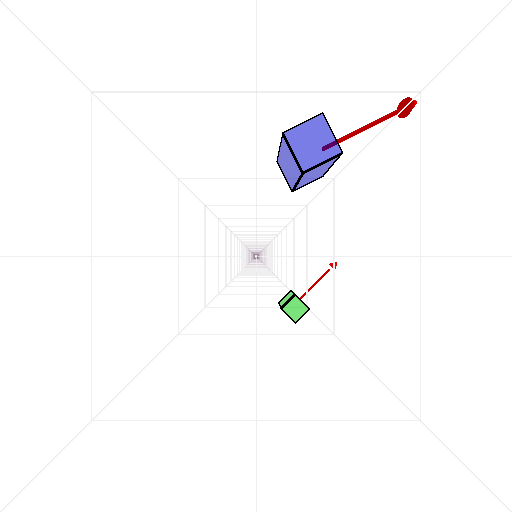

In [157]:
img